In [2]:
import torch
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
from torch.utils.data import DataLoader
from dataset.dataloader import CINE2DT
# from model.model_pytorch import CRNN_MRI
# from utils import multicoil2single, compressed_sensing as cs,IFFT2c
# from utils import multicoil2single, compressed_sensing as cs
# from utils.dnn_io import to_tensor_format, from_tensor_format
from utils.fastmriBaseUtils import FFT2c,IFFT2c
# from trainer_dcrnn_test import prep_input
from torch.autograd import Variable
import os 
from PIL import Image
# import scipy.io as sio
from scipy.io import loadmat
import scipy.io as scio
import h5py

os.environ['CUDA_VISIBLE_DEVICES'] = '7'  # 指定使用 GPU 1 和 GPU 4
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cuda = True if torch.cuda.is_available() else False
Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor

## 保存初始的CMR数据为label图片

In [9]:
def load_mat(fn_im_path):
    try:
        f = scio.loadmat(fn_im_path)
    except Exception:
        try:
            f = h5py.File(fn_im_path, 'r')
        except IOError:
            # print("File {} is defective and cannot be read!".format(fn_im_path))
            raise IOError("File {} is defective and cannot be read!".format(fn_im_path))
    return f

## 原始kspace和csm保存为图片（label）
# 加载 k-space 数据和线圈灵敏度图
#  train_subjs: '/nfs/zzy/data/k_gin_data/k_cine_multicoil_training.npy' # a demo
#   train_maps: '/nfs/zzy/data/k_gin_data/csm_cine_multicoil_training.npy' # a demo
#   val_subjs: '/nfs/zzy/data/k_gin_data/k_cine_multicoil_test.npy' # a demo
#   val_maps: '/nfs/zzy/data/k_gin_data/csm_cine_multicoil_test.npy' # a demo
# data = np.load('/nfs/zzy/data/k_gin_data/k_cine_multicoil_test.npy')
# csm = np.load('/nfs/zzy/data/k_gin_data/csm_cine_multicoil_test.npy')
  # train_subjs: '/data0/chentao/data/LplusSNet/data/20coil/k_cine_multicoil_training.npy' # a demo
  # train_maps: '/data0/chentao/data/LplusSNet/data/20coil/csm_cine_multicoil_training.npy' # a demo
  # val_subjs: '/data0/chentao/data/LplusSNet/data/20coil/k_cine_multicoil_test.npy' # a demo
  # val_maps: '/data0/chentao/data/LplusSNet/data/20coil/csm_cine_multicoil_test.npy' # a demo
data = np.load('/data0/chentao/data/LplusSNet/data/20coil/k_cine_multicoil_test.npy')
csm = np.load('/data0/chentao/data/LplusSNet/data/20coil/csm_cine_multicoil_test.npy')
print("data-shape-dtype:", data.shape,data.dtype)  # data: (800, coil=20, 18, 192, 192) (t,h,w)=(18, 192, 192)
print("csm-shape-dtype:", csm.shape,csm.dtype)  # data: (800, coil=20, 18, 192, 192) (t,h,w)=(18, 192, 192)

# 只取第一个样本
data = data[0, :, :, :, :]  # (coil=20, 18, 192, 192)
csm = csm[0, :, :, :, :]    # (coil=20, 18, 192, 192)

# 对 k-space 数据进行逆傅里叶变换，并与 CSM 结合生成图像
img = np.sum(IFFT2c(data) * np.conj(csm), axis=0)  # (18, 192, 192)
print("img:", img.shape)  # img: (18, 192, 192)

img = np.abs(img)  # 取模值显示

# 创建输出目录
output_dir = '/data0/zhiyong/code/github/itzzy_git/k_gin_base/utils/base'
os.makedirs(output_dir, exist_ok=True)

# 保存前五帧的两种版本
for i in range(5):
    # 原始归一化
    plt.imsave(
        os.path.join(output_dir, f'frame_{i}_original.png'),
        img[i], 
        cmap='gray',
        vmin=0, 
        vmax=np.max(img)  # 保持动态范围一致
    )
    
    # 亮度增强版（3倍亮度）
    plt.imsave(
        os.path.join(output_dir, f'frame_{i}_brightened.png'),
        np.clip(img[i] * 3, 0, np.max(img)),  # 限制最大值不超过原始最大值
        cmap='gray'
    )

print(f"图像已保存至：{output_dir}")

# 归一化并调整亮度
# img_max = np.max(np.abs(img))
# img_norm = np.abs(img) / img_max
# brightness_factor = 3
# img_brightened = np.clip(img_norm * brightness_factor, 0, 1)

# # 创建 base 目录
# output_dir = 'base'
# if not os.path.exists(output_dir):
#     os.makedirs(output_dir)

# # 保存前五张图片
# for i in range(5):
#     plt.imshow(img_brightened[i], cmap='gray')
#     plt.title(f'Frame {i}')
#     plt.axis('off')
#     plt.savefig(os.path.join(output_dir, f'frame_{i}.png'))  # 保存为 PNG 文件
#     plt.close()  # 关闭当前图像，避免重叠

# print(f"前五张图片已保存到 {output_dir} 目录下。")

data-shape-dtype: (118, 20, 18, 192, 192) complex64
csm-shape-dtype: (118, 20, 1, 192, 192) complex64
img: (18, 192, 192)
图像已保存至：/data0/zhiyong/code/github/itzzy_git/k_gin_base/utils/base


## 合并DCCNN、CRNN结果

In [ ]:
import numpy as np
import scipy.io as sio
import os
import re  # 新增正则表达式模块
from tqdm import tqdm

###ls用后面的代码
# 输入路径
input_dir = "/data0/zhiyong/data/CMR_data/single_coil/d5c5_acc_8/"
output_dir = "/data0/zhiyong/code/github/itzzy_git/k_gin_base/output/dccnn"

# 创建输出目录
os.makedirs(output_dir, exist_ok=True)

# 获取所有 .mat 文件并按数字排序（使用正则表达式过滤无效文件）
mat_files = sorted(
    [f for f in os.listdir(input_dir) 
     if re.match(r'^recon_(\d+)\.mat$', f)],  # 仅匹配 recon_数字.mat
    key=lambda x: int(re.search(r'(\d+)', x).group(1))  # 提取数字部分排序
)

# 初始化合并后的数据列表
merged_data = []

# 逐个加载并合并
for mat_file in tqdm(mat_files, desc="合并进度"):
    mat_path = os.path.join(input_dir, mat_file)
    data = sio.loadmat(mat_path)
    
    # 假设数据字段为 'recon'（需根据实际字段名调整）
    recon = data['recon']
    merged_data.append(recon)

# 转换为 NumPy 数组（维度示例: [num_samples, height, width]）
merged_array = np.array(merged_data)

# 保存为 .npy 文件
np.save(os.path.join(output_dir, "dccnn_acc_8_merge.npy"), merged_array)

# 保存为 .mat 文件（兼容 MATLAB）
sio.savemat(
    os.path.join(output_dir, "dccnn_acc_8_merge.mat"),
    {"merged_recon": merged_array},
    do_compression=True
)

print(f"合并完成！有效文件数量：{len(mat_files)}，输出目录：{output_dir}")

合并进度:   0%|          | 0/118 [00:00<?, ?it/s]


NotImplementedError: Please use HDF reader for matlab v7.3 files, e.g. h5py

## 使用 scipy.io.loadmat 读取 MATLAB v7.3 格式的 .mat 文件，而该格式基于 HDF5，需要改用 h5py 库读取。

In [6]:
import numpy as np
import h5py
import os
import re
from tqdm import tqdm

input_dir = "/data0/zhiyong/data/CMR_data/single_coil/ls_acc_12"
output_dir = "/data0/zhiyong/code/github/itzzy_git/k_gin_base/output/ls"

os.makedirs(output_dir, exist_ok=True)

mat_files = sorted(
    [f for f in os.listdir(input_dir) 
     if re.match(r'^recon_(\d+)\.mat$', f)],
    key=lambda x: int(re.search(r'(\d+)', x).group(1))
)

merged_data = []

for mat_file in tqdm(mat_files, desc="合并进度"):
    mat_path = os.path.join(input_dir, mat_file)
    # 使用 h5py 读取 v7.3 格式的 .mat 文件
    with h5py.File(mat_path, 'r') as f:
        recon = f['recon'][()]  # 获取数据
        # 调整维度顺序（MATLAB 使用 Fortran 列优先，需转置）
        recon = recon.T
    merged_data.append(recon)

merged_array = np.array(merged_data)

# 保存为 .npy 文件
np.save(os.path.join(output_dir, "ls_acc_12_merge.npy"), merged_array)

# 使用 h5py 保存为 v7.3 格式的 .mat 文件（兼容 MATLAB）
with h5py.File(os.path.join(output_dir, "ls_acc_12_merge.mat"), 'w') as f:
    f.create_dataset('merged_recon', data=merged_array, compression='gzip')

print(f"合并完成！有效文件数量：{len(mat_files)}，输出目录：{output_dir}")

合并进度: 100%|██████████| 118/118 [00:19<00:00,  6.06it/s]


合并完成！有效文件数量：118，输出目录：/data0/zhiyong/code/github/itzzy_git/k_gin_base/output/ls


## 保存前五张照片(原始数据是图片格式)

In [7]:
from utils.fastmriBaseUtils import FFT2c,IFFT2c
# 这种方法是将上一级目录添加到模块搜索路径中，然后进行导入。
# import sys
# sys.path.append("..")
# from UTILS import FFT2c, IFFT2c
# from UTILS import FFT2C, IFFT2C
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

def load_mat(fn_im_path):
    try:
        f = sio.loadmat(fn_im_path)
    except Exception:
        try:
            f = h5py.File(fn_im_path, 'r')
        except IOError:
            raise IOError("File {} is defective and cannot be read!".format(fn_im_path))
    return f

# 加载数据

# data = np.load('/nfs/zzy/code/k_gin_kv/output/r4/out_1220_r4.npy') #r4
# data = np.load('/nfs/zzy/code/k_gin_kv/output/r6/out_1205_r6_1.npy') # r6
# data = np.load('/nfs/zzy/code/k_gin_kv/output/r8/out_1205_2_r8.npy') #r8
## /data0/zhiyong/code/github/itzzy_git/k_gin_base/output/crnn/crnn_acc_8_merge.npy
data = np.load('/data0/zhiyong/code/github/itzzy_git/k_gin_base/output/ls/ls_acc_12_merge.npy')
print("data-1-shape:", data.shape)  # data: (118, 192, 192, 18)  data: (800, coil=20, 18, 192, 192) (t,h,w)=(18, 192, 192)

# 只取第一帧数据
data = data[0:1, :, :, :]
# 检查数据是否为结构化数组  ls的结果是结构化数组
if data.dtype.names is not None and ('real' in data.dtype.names) and ('imag' in data.dtype.names):
    # 提取实部和虚部并合并为复数
    real_part = data['real']
    imag_part = data['imag']
    data_complex = real_part.astype(np.complex64) + 1j * imag_part.astype(np.complex64)
else:
    data_complex = data.astype(np.complex64)

# 调整维度顺序
data_complex = data_complex.transpose(0, 3, 1, 2)  # (batch, time, height, width)
# print('data-2-dtype:',data.dtype) #data-2-dtype: complex64
# print('data-2-shape:',data.shape) #data-2-shape: (1, 192, 192, 18)
# data = data.transpose(0,3,1,2)

# 对数据进行逆傅里叶变换
# img = IFFT2c(data)
# 应用逆傅里叶变换
# img = IFFT2c(data_complex)
img = data_complex[0]  # 取第一个样本
# img = data[0]
# img = img[0,:,:]  # 取第一个样本
print("img:", img.shape)  # img: (18, 192, 192)
print("img dtype:", img.dtype)  # 查看数据类型 img dtype: [('real', '<f4'), ('imag', '<f4')]

# 归一化并调整亮度
img_max = np.max(np.abs(img))
img_norm = np.abs(img) / img_max
brightness_factor = 3
img_brightened = np.clip(img_norm * brightness_factor, 0, 1)

# # 创建 r4 目录
# output_dir = 'r4'
# # 创建 r6 目录
# output_dir = 'r6'
# 创建 r6 目录
output_dir = '/data0/zhiyong/code/github/itzzy_git/k_gin_base/output/ls/r12'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# 保存前五张图片
for i in range(5):
    plt.imshow(img_brightened[i], cmap='gray')
    plt.title(f'Frame {i}')
    plt.axis('off')
    plt.savefig(os.path.join(output_dir, f'frame_{i}.png'))  # 保存为 PNG 文件
    plt.close()  # 关闭当前图像，避免重叠

print(f"前五张图片已保存到 {output_dir} 目录下。")

data-1-shape: (118, 192, 192, 18)
img: (18, 192, 192)
img dtype: complex64
前五张图片已保存到 /data0/zhiyong/code/github/itzzy_git/k_gin_base/output/ls/r12 目录下。


In [7]:
from utils.fastmriBaseUtils import FFT2c, IFFT2c
import matplotlib.pyplot as plt
import numpy as np
import os

# 加载数据
# data = np.load('/data0/zhiyong/code/github/itzzy_git/k_gin_base/output/ls/ls_acc_8_merge.npy')
# data = np.load('/data0/zhiyong/code/github/itzzy_git/k_gin_base/output/dccnn/dccnn_acc_12_merge.npy')
data = np.load('/data0/zhiyong/code/github/itzzy_git/k_gin_base/output/cine_mask/r8/out_1209r_8.npy')
# 只取第一帧数据（保持4D结构）
data_subset = data[0:1]  # shape: (1, ...)

# 处理结构化数组（兼容旧数据格式）
if data_subset.dtype.names is not None:
    # 合并实部虚部为复数 (batch, h, w, time)
    data_complex = data_subset['real'].astype(np.complex64) + 1j * data_subset['imag'].astype(np.complex64)
    data_complex = data_complex.transpose(0, 3, 1, 2)  # (batch, time, h, w)
else:
    # 新格式直接转换 (假设维度已经是 [batch, time, h, w])
    data_complex = data_subset.astype(np.complex64)

# 应用逆傅里叶变换（如果数据是k空间）
# data_complex = IFFT2c(data_complex)  # 根据实际数据性质决定是否启用

# 提取第一个样本并调整维度顺序
img = data_complex[0]  # (time, h, w)
img = np.abs(img)  # 取模值显示

# 创建输出目录
# output_dir = '/data0/zhiyong/code/github/itzzy_git/k_gin_base/output/ls/r8'
# output_dir = '/data0/zhiyong/code/github/itzzy_git/k_gin_base/output/dccnn/r12'
output_dir = '/data0/zhiyong/code/github/itzzy_git/k_gin_base/output/cine_mask/r8'
os.makedirs(output_dir, exist_ok=True)

# 保存前五帧的两种版本
for i in range(5):
    # 原始归一化
    plt.imsave(
        os.path.join(output_dir, f'frame_{i}_original.png'),
        img[i], 
        cmap='gray',
        vmin=0, 
        vmax=np.max(img)  # 保持动态范围一致
    )
    
    # 亮度增强版（3倍亮度）
    plt.imsave(
        os.path.join(output_dir, f'frame_{i}_brightened.png'),
        np.clip(img[i] * 3, 0, np.max(img)),  # 限制最大值不超过原始最大值
        cmap='gray'
    )

print(f"图像已保存至：{output_dir}")

图像已保存至：/data0/zhiyong/code/github/itzzy_git/k_gin_base/output/cine_mask/r8


## 保存前五张照片(原始数据是kspace)

In [7]:
from utils.fastmriBaseUtils import FFT2c, IFFT2c
import matplotlib.pyplot as plt
import numpy as np
import os

# 加载数据
# data = np.load('/data0/zhiyong/code/github/itzzy_git/k_gin_base/output/ls/ls_acc_8_merge.npy')
# data = np.load('/data0/zhiyong/code/github/itzzy_git/k_gin_base/output/dccnn/dccnn_acc_12_merge.npy')
# data = np.load('/data0/zhiyong/code/github/itzzy_git/k_gin_base/output/cine_mask/r8/out_1209r_8.npy')
# data = np.load('/data0/zhiyong/code/github/itzzy_git/k_gin_base/output/cine_mask/r10/out_kgin_base_0118_r10.npy')
# data = np.load('/data0/zhiyong/code/github/itzzy_git/k_gin_base/output/cine_mask/r12/out_kgin_base_0118_r12.npy')
# data = np.load('/data0/zhiyong/code/github/itzzy_git/k_gin_kv/output/cine_mask/r4/out_1220_r4.npy')
# data = np.load('/data0/zhiyong/code/github/itzzy_git/k_gin_kv/output/cine_mask/r6/out_1206_r6.npy')
# data = np.load('/data0/zhiyong/code/github/itzzy_git/k_gin_kv/output/cine_mask/r8/out_1205_r8.npy')
# data = np.load('/data0/zhiyong/code/github/itzzy_git/k_gin_kv/output/cine_mask/r10/out_kgin_kv_0118_r10.npy')
data = np.load('/data0/zhiyong/code/github/itzzy_git/k_gin_kv/output/cine_mask/r12/out_kgin_kv_0118_r12.npy')
# 只取第一帧数据（保持4D结构）
data_subset = data[0:1]  # shape: (1, ...)

# 处理结构化数组（兼容旧数据格式）
if data_subset.dtype.names is not None:
    # 合并实部虚部为复数 (batch, h, w, time)
    data_complex = data_subset['real'].astype(np.complex64) + 1j * data_subset['imag'].astype(np.complex64)
    data_complex = data_complex.transpose(0, 3, 1, 2)  # (batch, time, h, w)
else:
    # 新格式直接转换 (假设维度已经是 [batch, time, h, w])
    data_complex = data_subset.astype(np.complex64)

# 应用逆傅里叶变换（如果数据是k空间）
# data_complex = IFFT2c(data_complex)  # 根据实际数据性质决定是否启用

# 提取第一个样本并调整维度顺序
# img = data_complex[0]  # (time, h, w)
img_complex = IFFT2c(data_complex)
img = np.abs(img_complex[0])  # 取模值显示

# 创建输出目录
# output_dir = '/data0/zhiyong/code/github/itzzy_git/k_gin_base/output/ls/r8'
# output_dir = '/data0/zhiyong/code/github/itzzy_git/k_gin_base/output/dccnn/r12'
# output_dir = '/data0/zhiyong/code/github/itzzy_git/k_gin_base/output/cine_mask/r12'
output_dir = '/data0/zhiyong/code/github/itzzy_git/k_gin_kv/output/cine_mask/r12/'
os.makedirs(output_dir, exist_ok=True)

# 保存前五帧的两种版本
for i in range(5):
    # 原始归一化
    plt.imsave(
        os.path.join(output_dir, f'frame_{i}_original.png'),
        img[i], 
        cmap='gray',
        vmin=0, 
        vmax=np.max(img)  # 保持动态范围一致
    )
    
    # 亮度增强版（3倍亮度）
    plt.imsave(
        os.path.join(output_dir, f'frame_{i}_brightened.png'),
        np.clip(img[i] * 3, 0, np.max(img)),  # 限制最大值不超过原始最大值
        cmap='gray'
    )

print(f"图像已保存至：{output_dir}")

图像已保存至：/data0/zhiyong/code/github/itzzy_git/k_gin_kv/output/cine_mask/r12/


## 计算两张MRI图像的PSNR（峰值信噪比）
### ​两种计算方法：
​手动计算：直接根据公式 PSNR = 20*log10(MAX) - 10*log10(MSE) 实现

​scikit-image库：使用现成的peak_signal_noise_ratio函数（更可靠）

### ​典型结果解读：
PSNR > 40 dB：重建质量优秀

30 dB < PSNR < 40 dB：质量可接受

PSNR < 30 dB：质量较差

In [10]:
import cv2
import numpy as np
from skimage.metrics import peak_signal_noise_ratio

# 图像路径
# label_path = "/data0/zhiyong/code/github/itzzy_git/k_gin_base/utils/base/frame_0.png"
label_path = '/data0/zhiyong/code/github/itzzy_git/k_gin_base/utils/base/frame_0_original.png'
# recon_path = "/data0/zhiyong/code/github/itzzy_git/k_gin_base/output/crnn/r8/frame_0.png"
# recon_path = '/data0/zhiyong/code/github/itzzy_git/k_gin_base/utils/r4/frame_0.png'
recon_path = '/data0/zhiyong/code/github/itzzy_git/k_gin_base/output/ls/r8/frame_0_original.png'

try:
    # 读取图像（灰度模式）
    label_img = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)
    recon_img = cv2.imread(recon_path, cv2.IMREAD_GRAYSCALE)

    if label_img is None or recon_img is None:
        raise FileNotFoundError("无法读取图像文件，请检查路径是否正确")

    # 确保图像尺寸相同
    if label_img.shape != recon_img.shape:
        raise ValueError("图像尺寸不匹配")

    # 方法1：手动计算PSNR
    # mse = np.mean((label_img.astype(np.float64) - recon_img.astype(np.float64)) ​** 2)
    mse = np.mean((label_img.astype(np.float64) - recon_img.astype(np.float64))**2)
    print('mse:',mse)
    if mse == 0:
        psnr = float('inf')
    else:
        psnr = 20 * np.log10(255.0 / np.sqrt(mse))

    # 方法2：使用scikit-image库（推荐）
    psnr_skimage = peak_signal_noise_ratio(label_img, recon_img, data_range=255)

    print(f"[手动计算] PSNR: {psnr:.2f} dB")
    print(f"[scikit-image] PSNR: {psnr_skimage:.2f} dB")

except Exception as e:
    print(f"错误: {str(e)}")

mse: 13.228325737847221
[手动计算] PSNR: 36.92 dB
[scikit-image] PSNR: 36.92 dB


In [ ]:
# im=[1,30,256,256]
# label_path = "/data0/zhiyong/code/github/itzzy_git/k_gin_base/utils/base/frame_0.png"
## /data0/zhiyong/code/github/itzzy_git/k_gin_base/output/crnn/crnn_acc_8_merge.npy
# data = np.load('/data0/zhiyong/code/github/itzzy_git/k_gin_base/output/ls/ls_acc_12_merge.npy')
data = np.load('/data0/zhiyong/code/github/itzzy_git/k_gin_base/output/crnn/crnn_acc_8_merge.npy')
print("data-1-shape:", data.shape)  # data: (118, 192, 192, 18)  data: (800, coil=20, 18, 192, 192) (t,h,w)=(18, 192, 192)

# 只取第一帧数据
data = data[0:1, :, :, :]
# 检查数据是否为结构化数组  ls的结果是结构化数组
if data.dtype.names is not None and ('real' in data.dtype.names) and ('imag' in data.dtype.names):
    # 提取实部和虚部并合并为复数
    real_part = data['real']
    imag_part = data['imag']
    data_complex = real_part.astype(np.complex64) + 1j * imag_part.astype(np.complex64)
else:
    data_complex = data.astype(np.complex64)

# 调整维度顺序
data_complex = data_complex.transpose(0, 3, 1, 2)  # (batch, time, height, width)
# print('data-2-dtype:',data.dtype) #data-2-dtype: complex64
# print('data-2-shape:',data.shape) #data-2-shape: (1, 192, 192, 18)
# data = data.transpose(0,3,1,2)

# 对数据进行逆傅里叶变换
# img = IFFT2c(data)
# 应用逆傅里叶变换
# img = IFFT2c(data_complex)
# im = data_complex[0]  # 取第一个样本
im = data_complex

###生成shear_grid 的mask
# print('im-shape:',im.shape)
acc = 8
mask = cs.shear_grid_mask(im.shape[1:], acc, sample_low_freq=True,centred=True,sample_n=4)
mask = np.repeat(mask[np.newaxis], im.shape[0], axis=0)
print('mask-shape-1:',mask.shape) #mask-shape: (1, 18, 192, 192)
mask = mask[0,:,:,:]
print('mask-shape-2:',mask.shape) #mask-shape: mask-shape-2: (18, 192, 192)

scio.savemat('masks/VISTA/shear_grid_18_192_192_sample_n_4_acc_8.mat', {'mask': mask})

# 显示图像域的数据
plt.figure(figsize=(6, 6))
plt.imshow(mask[0,0,:,:], cmap='gray')  # 使用灰度颜色映射
plt.title("mask -1  (第 0 帧)")
plt.axis('off')
plt.show()

plt.figure(figsize=(6, 6))
plt.imshow(mask[0,:,:,0], cmap='gray')  # 使用灰度颜色映射
plt.title("mask -1  (第 0 帧)")
plt.axis('off')
plt.show()

data-1-shape: (118, 192, 192, 18)
mask-shape-1: (1, 18, 192, 192)
mask-shape-2: (18, 192, 192)


IndexError: too many indices for array: array is 3-dimensional, but 4 were indexed

<Figure size 600x600 with 0 Axes>

In [ ]:
import numpy as np
import torch

# 加载.npy文件
val_subjs = np.load('/nfs/zzy/data/k_gin_data/k_cine_multicoil_test.npy')
val_maps = np.load('/nfs/zzy/data/k_gin_data/csm_cine_multicoil_test.npy')

# 将numpy数组转换为PyTorch张量
val_subjs_tensor = torch.from_numpy(val_subjs)
val_maps_tensor = torch.from_numpy(val_maps)

# 查看维度
# val_subjs dimensions: torch.Size([118, 20, 18, 192, 192])
# val_maps dimensions: torch.Size([118, 20, 1, 192, 192])
'''
根据你提供的维度信息，每个维度可能有特定的含义，这通常取决于数据集的上下文。以下是根据常见的数据集和MRI（磁共振成像）数据的一般情况，对每个维度的可能含义的推测：
val_subjs dimensions: torch.Size([118, 20, 18, 192, 192])
第一个维度 [118]：可能表示数据集中的样本数量或不同的主题（subjects）。
第二个维度 [20]：可能表示每个样本的时间序列长度，或者不同的切片（slices）。
第三个维度 [18]：可能表示不同的通道（channels），在MRI数据中，这可能表示不同的线圈接收到的信号。 时间t
第四个维度 [192]：可能表示图像的高度。
第五个维度 [192]：可能表示图像的宽度。

val_maps dimensions: torch.Size([118, 20, 1, 192, 192])
第一个维度 [118]：与 val_subjs 的第一个维度相同，表示样本数量或不同的主题。
第二个维度 [20]：与 val_subjs 的第二个维度相同，表示时间序列长度或不同的切片。
第三个维度 [1]：表示通道数，这里只有一个通道，可能是一个单通道的映射（map），例如一个密度图或权重图。
第四个维度 [192]：与 val_subjs 的第四个维度相同，表示图像的高度。
第五个维度 [192]：与 val_subjs 的第五个维度相同，表示图像的宽度。
这些解释是基于一般的MRI数据处理和图像数据的维度约定。具体的含义可能依赖于数据集的文档或数据生成过程。
如果你有数据集的文档，建议查阅以获取确切的维度含义。如果文档不可用，你可能需要联系数据集的提供者或查看相关的研究论文来了解每个维度的具体含义。
'''
print("val_subjs dimensions:", val_subjs_tensor.shape)
print("val_maps dimensions:", val_maps_tensor.shape)


val_subjs dimensions: torch.Size([118, 20, 18, 192, 192])
val_maps dimensions: torch.Size([118, 20, 1, 192, 192])


data: (118, 18, 192, 192)
img: (18, 192, 192)


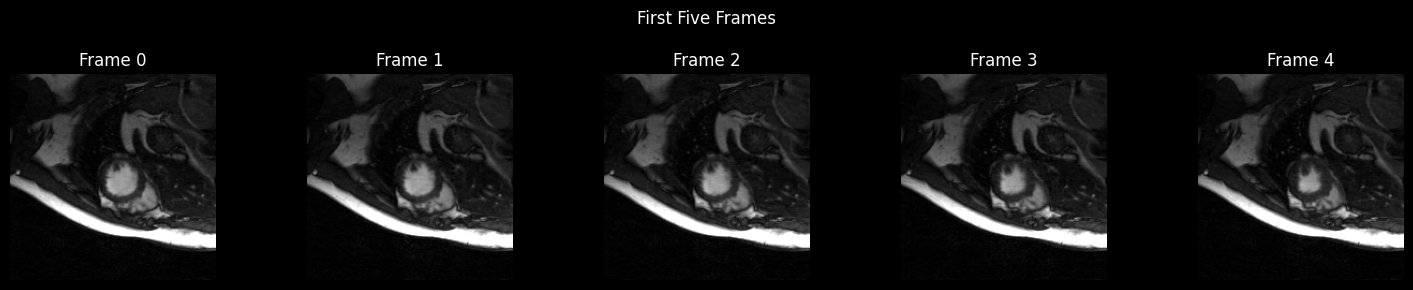

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# 加载数据
# data = np.load('/nfs/zzy/code/k_gin_base/output/r4/out_1220_r4.npy')
data = np.load('/data0/zhiyong/code/github/itzzy_git/k_gin_base/output/cine_mask/r4/out_1220_r4.npy')
print("data:", data.shape)  # data: (800, coil=20, 18, 192, 192) (t,h,w)=(18, 192, 192)

# 选择数据的一个切片
# data = data[100:101, :, :, :]
data = data[80:81, :, :, :]
# data = data[0:1, :, :, :]

# 假设 IFFT2c 是一个函数，用于计算逆傅里叶变换
# 由于代码中没有提供 IFFT2c 函数的定义，这里假设它已经定义好了
img = IFFT2c(data)
img = img[0]
print("img:", img.shape)

# 归一化并增强亮度
img_max = np.max(np.abs(img))
img_norm = np.abs(img) / img_max
brightness_factor = 3
img_brightened = np.clip(img_norm * brightness_factor, 0, 1)

# 创建一个图像网格来显示前五张图片
fig, axs = plt.subplots(1, 5, figsize=(15, 3))  # 1行5列的子图
fig.suptitle('First Five Frames')  # 设置总标题

# 遍历前五张图片并显示在子图中
for i in range(5):
    axs[i].imshow(img_brightened[i], cmap='gray')
    axs[i].set_title(f'Frame {i}')
    axs[i].axis('off')  # 关闭坐标轴

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # 调整布局以避免标题重叠
plt.show()


## 顺时针旋转90度显示

data: (118, 18, 192, 192)


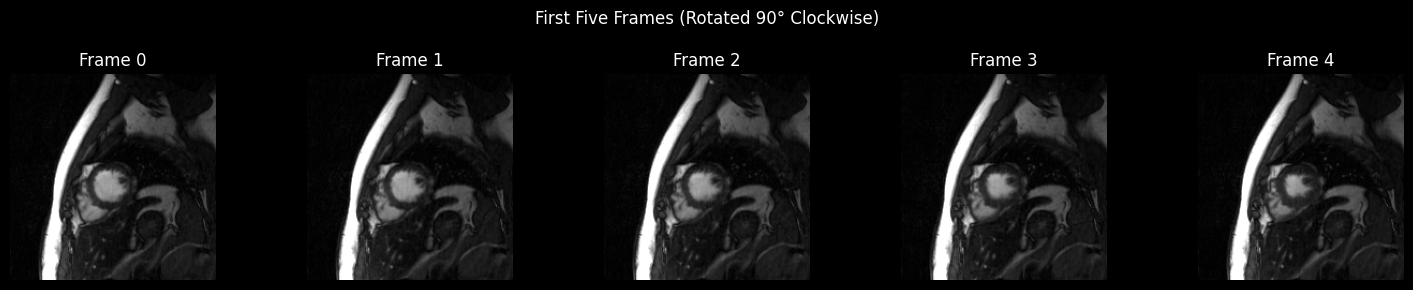

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# 加载数据
data = np.load('/data0/zhiyong/code/github/itzzy_git/k_gin_base/output/cine_mask/r4/out_1220_r4.npy')
print("data:", data.shape)  # data: (800, coil=20, 18, 192, 192)

# 选择数据的一个切片
data = data[80:81, :, :, :]

# 逆傅里叶变换
img = IFFT2c(data)
img = img[0]  # 取第一个样本，形状 (18, 192, 192)

# 归一化并增强亮度
img_max = np.max(np.abs(img))
img_norm = np.abs(img) / img_max
brightness_factor = 3
img_brightened = np.clip(img_norm * brightness_factor, 0, 1)

# 创建子图
fig, axs = plt.subplots(1, 5, figsize=(15, 3))
fig.suptitle('First Five Frames (Rotated 90° Clockwise)')

# 显示前五帧（旋转后）
for i in range(5):
    # 顺时针旋转90度（两种等效方式）：
    # 方法一：使用 np.rot90 旋转270度（即逆时针270度=顺时针90度）
    rotated_frame = np.rot90(img_brightened[i], k=3) 
    
    # 方法二：转置后水平翻转（更高效）
    # rotated_frame = img_brightened[i].T[::-1, :]
    
    axs[i].imshow(rotated_frame, cmap='gray')
    axs[i].set_title(f'Frame {i}')
    axs[i].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()